#  COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning Code

first we will train our model then used for detections 

Training: Here we’ll focus on loading our face mask detection dataset from disk, training a model (using Keras/TensorFlow) on this dataset, and then serializing the face mask detector to disk


Deployment: Once the face mask detector is trained, we can then move on to loading the mask detector, performing face detection, and then classifying each face as with_mask
or without_mask

# Implementing our COVID-19 face mask detector training script with Keras and TensorFlow 2.0

Imports Libraries

In [1]:
import os
import argparse
import numpy as np
from imutils import paths

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical


 load and pre-process our training data:

#grab the list of images in our dataset directory, then initialize
#the list of data (i.e., images) and class images

In [2]:
image_Paths = list(paths.list_images(r"C:\Users\SRKT\Desktop\face-mask-detector\face-mask-detector\dataset"))
data = []
labels = []
# loop over the image paths
for image_Path in image_Paths:
    # extract the class label from the filename
    label = image_Path.split(os.path.sep)[-2]
    
    #load the input image(224,224) and preprocess it
    image=load_img(image_Path,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    
    #update data and labels
    labels.append(label)
    data.append(image)

    
#convert the data and labels into  numpy arrays
data=np.array(data,dtype="float32")
labels=np.array(labels)
    


hyperparameters 

In [3]:
batch_size=20
epochs=20
lr=1e-4

encode our labels
, partition our dataset, and prepare for data augmentation:

In [4]:
#perform one hot encoding on the labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

#spliting data in training and testing
(x_train,x_test,y_train,y_test)=train_test_split(data,labels,test_size=0.2,stratify=labels,
                                              random_state=42)


#construct the training image data generator for data augmentation
aug_data=ImageDataGenerator(rotation_range=20,
                           zoom_range=0.15,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.15,
                           horizontal_flip=True,
                           fill_mode='nearest')

MobileNetV2 transfer learning with fine-tuning 

In [9]:
#load the MobileNetV2 network ensuring the head FC  layer sets are left off
base_Model=MobileNetV2(weights="imagenet",include_top=False,
                      input_tensor=Input(shape=(224,224,3)))

#construct the head model and placed in top of the base model
head_Model=base_Model.output
head_Model=AveragePooling2D(pool_size=(7,7))(head_Model)
head_Model=Flatten(name="Flatten")(head_Model)
head_Model=Dense(128,activation='relu')(head_Model)
head_Model=Dropout(0.5)(head_Model)
head_Model=Dense(2,activation="softmax")(head_Model)

#place the head FC model on top of base model (this will actual model we will train)
model=Model(inputs=base_Model.input,outputs=head_Model)

#loop over all the layers in the base model and freeze them so they will not be updated during first training
for layer in base_Model.layers:
    layer.trainable=False

compile and train our face mask detector network

In [13]:
#compile our model
print("[INFO] compiling our model")
opt=Adam(lr=lr,decay=lr/batch_size)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

#train the head of the network
print("[INFO] training head....")
H=model.fit(
            aug_data.flow(x_train,y_train,batch_size=batch_size),
            steps_per_epoch=len(x_train)//batch_size,
            validation_data=(x_test,y_test),
            validation_steps=len(x_test)//batch_size,
            epochs=epochs)

[INFO] compiling our model
[INFO] training head....
Train on 1100 samples, validate on 276 samples
Epoch 1/20


W0512 22:10:47.233421 13560 deprecation.py:323] From c:\python36\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1100/1100 [==============================] - 170s 155ms/sample - loss: 0.6576 - accuracy: 0.6600 - val_loss: 0.3425 - val_accuracy: 0.8615
Epoch 2/20
1100/1100 [==============================] - 136s 124ms/sample - loss: 0.3629 - accuracy: 0.8436 - val_loss: 0.2973 - val_accuracy: 0.8462
Epoch 3/20
1100/1100 [==============================] - 137s 125ms/sample - loss: 0.2639 - accuracy: 0.8955 - val_loss: 0.1499 - val_accuracy: 0.9615
Epoch 4/20
1100/1100 [==============================] - 136s 124ms/sample - loss: 0.2316 - accuracy: 0.9036 - val_loss: 0.1478 - val_accuracy: 0.9385
Epoch 5/20
1100/1100 [==============================] - 136s 124ms/sample - loss: 0.1963 - accuracy: 0.9200 - val_loss: 0.1397 - val_accuracy: 0.9423
Epoch 6/20
1100/1100 [==============================] - 135s 123ms/sample - loss: 0.1834 - accuracy: 0.9327 - val_loss: 0.0957 - val_accuracy: 0.9692
Epoch 7/20
1100/1100 [==============================] - 135s 122ms/sample - loss: 0.1503 - accuracy: 0.9400 - v

evaluate the resulting model on the test set:

In [21]:
#making the predictions on testing set
print("[INFO] evaluating networks")
predIdxs=model.predict(x_test,batch_size=batch_size)

#for each image in the testing set we need to find the index of the label corresponding largest prediction prob.
predIdxs=np.argmax(predIdxs,axis=1)

#classification result
print(classification_report(y_test.argmax(axis=1),predIdxs,target_names=lb.classes_))



[INFO] evaluating networks
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       138
without_mask       0.99      0.98      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [29]:
#save the model weight and model architecture together into single file H5 file
print("[INFO] saving our model")
model.save(r"C:\Users\SRKT\Desktop\face-mask-detector\model.h5")

[INFO] saving our model


 plot our accuracy and loss curves:

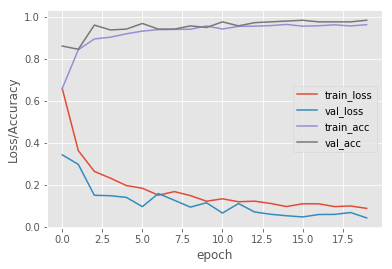

In [37]:
#plot the training loss and accuracy
n=epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,n),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,n),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n),H.history["val_accuracy"],label="val_acc")
plt.xlabel("epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
